In [1]:
%matplotlib ipympl
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
import numpy as np
import scipy
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist, plot_bode
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import string
import pandas as pd

In [2]:
def add_noise(z,err):
    #err is the relative SD from mean value
    z_with_noise=np.random.normal(np.real(z),err*np.abs(np.real(z)))+1j*np.random.normal(np.imag(z),err*np.abs(np.imag(z)))
    return z_with_noise

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

def give_xylim(zin,z0):
        zin_real=np.real(zin)
        zin_imag=np.imag(zin)

        z0_real=np.real(z0)
        z0_imag=np.imag(z0)

        max_0=np.maximum(np.max(z0_real),np.max(-z0_imag))
        max_in=np.maximum(np.max(zin_real),np.max(-zin_imag))

        xylim=np.maximum(max_0,max_in)
        return xylim

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def give_SSv(zexp,zmodel,wt,num):
    #zwt=give_weights2(zmodel,wt=wt)
    zexpr=np.real(zexp)
    zmodelr=np.real(zmodel)
    zexpj=-np.imag(zexp)
    zmodelj=-np.imag(zmodel)
    if(wt=="unit" or wt==""):
       SSv=(1/(2*len(zexp)-num))*np.sum((zexpr-zmodelr)**2+(zexpj-zmodelj)**2)
    elif(wt=="mod"):
       SSv=(1/(2*len(zexp)-num))*np.sum(((zexpr-zmodelr)/np.abs(zmodel))**2+((zexpj-zmodelj)/np.abs(zmodel))**2)
    elif(wt=="prop"):
       SSv=(1/(2*len(zexp)-num))*np.sum(((zexpr-zmodelr)/(zmodelr))**2+((zexpj-zmodelj)/(zmodelr))**2)
    return SSv

def give_SS(zexp,zmodel,wt):
     #zwt=give_weights2(zmodel,wt=wt)
     #zwt=give_weights(zmodel,wt=wt)
     zexpr=np.real(zexp)
     zmodelr=np.real(zmodel)
     zexpj=-np.imag(zexp)
     zmodelj=-np.imag(zmodel)
     if(wt=="unit" or wt==""):
       SS=np.sum((zexpr-zmodelr)**2+(zexpj-zmodelj)**2)
     elif(wt=="mod"):
       SS=np.sum(((zexpr-zmodelr)/np.abs(zmodel))**2+((zexpj-zmodelj)/np.abs(zmodel))**2)
     elif(wt=="prop"):
       SS=np.sum(((zexpr-zmodelr)/(zmodelr))**2+((zexpj-zmodelj)/(zmodelr))**2)
     return SS

In [3]:
@element(num_params=5, units=["Ohm", "Ohm", "","F",""],overwrite=True)
def TLMtwo(p, f):
   
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, delta1, alpha = p[0], p[1], p[2], p[3], p[4]
    Q=R1Q/R1
    R2=R2Q/Q
    delta2=1-delta1
    k12=R1/R2
    wc1=1/(R1*Q)
    wc2=1/(R2*Q)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)

    Z=2*(R1)*(C1*C2*S1*k12+S2)/(S1*(C2*S1*k12+C1*S2))

    return Z

@element(num_params=7, units=["Ohm", "Ohm", "Ohm", "","", "F",""],overwrite=True)
def TLMthree(p, f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, R3Q, delta1, delta2, alpha = p[0], p[1], p[2],p[3], p[4], p[5], p[6]
    delta3=1-delta1-delta2
    delta2=delta2
    Q=R1Q/R1
    R2=R2Q/Q
    R3=R3Q/Q
    k12=R2/R1
    k13=R3/R1
    wc1=1/(R1*Q)
    wc2=1/(R2*Q)
    wc3=1/(R3*Q)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    S3=np.sqrt((omega*1j)**alpha/wc3)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)
    C3=1/np.tanh(delta3*S3)

    Z=2*(R1)*((S1*S3*C1*k12**2+S2*C2*(S1*C1*C3*k13+S3)*k12+S2**2*C3*k13)/(S1*(S3*S1*k12**2+S2*C2*(S3*C1+S1*C3*k13)*k12+S2**2*C1*C3*k13)))

    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMlin(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, alpha = p[0], p[1], p[2], p[3]
    Q=R1Q/R1
    R2=R2Q/Q
    t12=R1/R2
    S=np.sqrt((1j*omega)**alpha*R1*Q)
    kk1=-2/3*(S*(t12**(-1/2)/(t12-1)))
    kk2=-2/3*(t12*S/(t12-1))
    Z = (2*R1/S)*(scipy.special.iv(1/3, kk1)*scipy.special.iv(2/3, kk2)-scipy.special.iv(-1/3, kk1)*scipy.special.iv(-2/3, kk2))/((scipy.special.iv(-1/3, kk1))*scipy.special.iv(1/3, kk2)-scipy.special.iv(1/3, kk1)*scipy.special.iv(-1/3, kk2))
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMlinzert(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, alpha = p[0], p[1], p[2], p[3]
    Q=R1Q/R1
    R2=R2Q/Q
    eps=(R2-R1)/R1
    S=np.sqrt((R1*Q*(omega*1j)**alpha))

    #second expansion
    Z=2*4*R1*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4-2/3*(S**3)+2*S**2-5/2*S+1/8)*eps**2+(4*S**3+S)*eps-4*S**2)*np.exp(2*S)+((-S**4-2/3*(S**3)-2*S**2-5/2*S-1/8)*eps**2+(4*S**3+S)*eps+4*S**2)*np.exp(4*S)+(4*S**2-S*eps+7/8*(eps**2))*np.exp(6*S)-4*S**2-S*eps-7*eps**2*(1/8)))
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMilin(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, alpha = p[0], p[1], p[2], p[3]
    Q=R1Q/R1
    R2=R2Q/Q
    t12=R1/R2
    wclin1=1/(R1*Q)
    wclin2=1/(R2*Q)
    S1=np.sqrt((1j*omega)**alpha/wclin1)
    S2=np.sqrt((1j*omega)**alpha/wclin2)
    
    Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1/(t12-1))))-((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(0,-2*1j*S1/(t12-1)))))/(((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(1,-2*1j*S1/(t12-1))))-((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(1,-2*1j*S1/(t12-1)))))
    
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMilinzert(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R1Q, R2Q, alpha = p[0], p[1], p[2], p[3]
    Q=R1Q/R1
    R2=R2Q/Q
    wclin1=1/(R1*Q)
    eps=R1/R2-1
    S=np.sqrt((1j*omega)**alpha/wclin1)

    Z=2*R1*4*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4+2*S**3+2*S**2+3/2*S+9/8)*eps**2+(-4*S**3-S)*eps-4*S**2)*np.exp(2*S)+((-S**4+2*S**3-2*S**2+3/2*S-9/8)*eps**2+(-4*S**3-S)*eps+4*S**2)*np.exp(4*S)+(-(1/8)*eps**2+S*eps+4*S**2)*np.exp(6*S)-4*S**2+S*eps+(1/8)*eps**2))
    
    return Z

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")
C:\Users\admin\AppData\Local\Temp\ipykernel_15428\3462066255.py:84: RuntimeWarning: divide by zero encountered in divide
  Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1/(t12-1))))-((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(0,-2*1j*S1/(t12-1)))))/(((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(1,-2*1j*S1/(t12-1))))-((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(1,-2*1j*S1/(t12-1)))))
C:\Users\admin\AppData\Local\Temp\ipykernel_15428\3462066255.py:84: RuntimeWarning: invalid value encountered in divide
  Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*

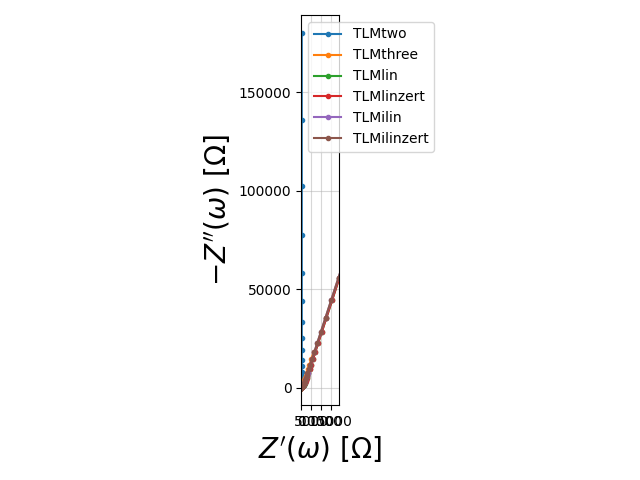

In [8]:
freq=np.logspace(-3,3,50)
c_two=CustomCircuit(initial_guess=[1000,6,2,0.2063,1],circuit="TLMtwo")
c_three=CustomCircuit(initial_guess=[1000,6,2,2,0.2063,0.4,0.8],circuit="TLMthree")
c_lin=CustomCircuit(initial_guess=[1000,1,5,0.8],circuit="TLMlin")
c_lin_zert=CustomCircuit(initial_guess=[1000,1,5,0.8],circuit="TLMlinzert")
c_ilin=CustomCircuit(initial_guess=[1000,1,5,0.8],circuit="TLMilin")
c_ilin_zert=CustomCircuit(initial_guess=[1000,1,5,0.8],circuit="TLMilinzert")

c_all=[c_two, c_three, c_lin, c_lin_zert,c_ilin,c_ilin_zert]

z_two=c_two.predict(freq)
z_three=c_three.predict(freq)
z_lin=c_lin.predict(freq)
z_lin_zert=c_lin_zert.predict(freq)
z_ilin=c_ilin.predict(freq)
z_ilin_zert=c_ilin_zert.predict(freq)

z_all=[z_two,z_three, z_lin, z_lin_zert, z_ilin, z_ilin_zert]

fig, ax=plt.subplots()
for c,z in zip(c_all,z_all):
    plot_nyquist(Z=z,ax=ax,label=c.circuit)


ax.set_xlim(0,3*np.max(np.real(z_three)))
plt.tight_layout()
plt.legend()